In [31]:
import sys
sys.path.append("..")

from functools import reduce

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

from modules import Retina
from utils import array2img, img2array

sys.path.append("..")

import torch

import model
import utils

from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

import data_loader
from config import get_config


In [2]:
#load the model (code from load_checkpoint function in trainer.py):

config, unparsed = get_config()


filename = "../ckpt/ram_6_1x1_1_model_best.pth.tar"

ckpt = torch.load(filename) #model

# build RAM model
config, unparsed = get_config()

ram0 = model.RecurrentAttention(
    1,
    config.num_patches,
    config.glimpse_scale,
    1,
    config.loc_hidden,
    config.glimpse_hidden,
    config.std,
    config.hidden_size,
    10,
)

ram0.load_state_dict(ckpt["model_state"])

<All keys matched successfully>

In [3]:
print(" Model data:\n patch size: " + str(config.patch_size) + 
    "\n num_patches: " + str(config.num_patches)+
    "\n glimpse_scale: " + str(config.glimpse_scale)+
    "\n num_channels: " + str(1)+
    "\n loc_hidden: " + str(config.loc_hidden)+
    "\n glimpse_hidden: " + str(config.glimpse_hidden)+
    "\n std: " + str(config.std)+
    "\n hidden_size: " + str(config.hidden_size)+
    "\n num_classes: " + str(10))

 Model data:
 patch size: 1
 num_patches: 1
 glimpse_scale: 1
 num_channels: 1
 loc_hidden: 128
 glimpse_hidden: 128
 std: 0.05
 hidden_size: 256
 num_classes: 10


In [4]:
def reset():
    h_t = torch.zeros(
        1,
        config.hidden_size,
        dtype=torch.float,
        requires_grad=True,
    )
    l_t = torch.FloatTensor(
        1, 2).uniform_(-1, 1)
    l_t.requires_grad = True

    return h_t, l_t

In [6]:
normalize = transforms.Normalize((0.1307,), (0.3081,))
trans = transforms.Compose([transforms.ToTensor(), normalize])

dataset = datasets.MNIST("../data", train=False, download=True, transform=trans)


In [25]:
mnistImage, label = dataset[11]
mnistImage = mnistImage.unsqueeze(1)

#do 10 glimpses
h_t, l_t = reset()

loc_list = []
for t in range(5):
    # forward pass through model
    h_t, l_t, b_t, p = ram0(mnistImage, l_t, h_t)
    loc_list.append(l_t)

# last iteration
h_t, l_t, b_t, log_probas, p = ram0(mnistImage, l_t, h_t, last=True)

pred = log_probas.data.max(1, keepdim=True)[1][0][0].item()
print("Prediction: " + str(pred) + ", actual: " + str(label))

Prediction: 8, actual: 6


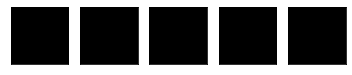

In [26]:
num_patches = config.num_patches
scale = config.glimpse_scale
patch_size = config.patch_size

glimpses = []
for loc in loc_list:
    ret = Retina(g=patch_size, k=num_patches, s=scale)
    glimpse = ret.foveate(mnistImage, loc).data.numpy()
    glimpse = np.reshape(glimpse, [1, num_patches, 1, patch_size, patch_size])
    glimpse = np.transpose(glimpse, [0, 1, 3, 4, 2])
    glimpses.append(glimpse)

    
fig, axs = plt.subplots(nrows=1, ncols=len(glimpses))
for i, ax in enumerate(axs.flat):
    axs[i].imshow(glimpses[i][0][0], cmap="gray")
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
plt.show()

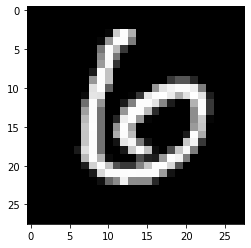

In [27]:
plt.imshow(mnistImage[0][0], cmap="gray")

In [56]:
mnistImage[0].shape

torch.Size([1, 28, 28])

# Make intensity function at location

In [28]:
#return form: tensor([[[-0.4242]]])

#current extract patch code:

      """
        B, C, H, W = x.shape

        start = self.denormalize(H, l)
        end = start + size
        # pad with zeros
        # x = F.pad(x, (size // 2, size // 2, size // 2, size // 2))
        x = F.pad(x, (1, 1, 1, 1))
        print(x.shape)

        # loop through mini-batch and extract patches
        patch = []
        for i in range(B):
            print(x[i, :, start[i, 1]: end[i, 1], start[i, 0]: end[i, 0]])

            patch.append(
                x[i, :, start[i, 1]: end[i, 1], start[i, 0]: end[i, 0]])
        return torch.stack(patch)
"""

torch.Size([1, 1, 28, 28])

In [48]:
#testing denormalize function

"""Convert coordinates in the range [-1, 1] to
        coordinates in the range [0, T] where `T` is
        the size of the image.
        
        return (0.5 * ((coords + 1.0) * T)).long()
"""
H1 = 15
loc1 = torch.tensor([0.1, -0.09])
Retina.denormalize(_, H1, loc1)

tensor([8, 6])

In [52]:
torch.tensor(4.3).long()

tensor(4)

In [126]:
def pointCharge(r, q):
    return -q/r**2

def intensity(loc, img): #loc is tensor([index1, index2]), img is tensor with shape: (1,H,W), generally H=W
    totalCharge = 0
    nRows, nColumns = img.shape
    xLoc = loc[1].item()
    yLoc = loc[0].item()
    for yi in range(nRows):
        for xi in range(nColumns):
            r2 = ((xLoc - xi) ** 2 + (yLoc - yi) ** 2)
            if(r2 != 0):
                pointCharge = img[yi,xi]/r2
                totalCharge += pointCharge
    return totalCharge


In [127]:
img1 = np.arange(25).reshape(5,5)
img1

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [128]:
torch.tensor([0,4])[1].item()

4

In [130]:
loc1 = torch.tensor([1, 6])

intensity(loc1, mnistImage[0][0])

tensor(-1.6773)

In [154]:
testImg1 = np.zeros([5,5])
testImg1[0,0] = 1
testImg1[2,2] = 0.1
testLoc1 = torch.tensor([2,2])
intensity(testLoc1, testImg1)

0.125

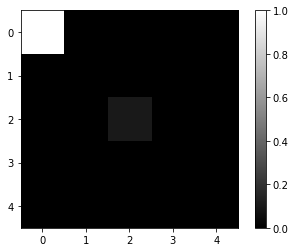

In [157]:
plt.imshow(testImg1, cmap="gray")
plt.colorbar()